In [1]:
import copy
from pathlib import Path
import warnings

import torch
import numpy as np
import pandas as pd
from glob import glob

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [84]:
data = pd.read_pickle('../M5_Dataset/tft_dataset.pkl')

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135870 entries, 0 to 135869
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   store_id      135870 non-null  category      
 1   dept_id       135870 non-null  category      
 2   state_id      135870 non-null  category      
 3   cat_id        135870 non-null  category      
 4   Node          135870 non-null  category      
 5   d             135870 non-null  int16         
 6   sold          135870 non-null  float64       
 7   date          135870 non-null  datetime64[ns]
 8   weekday       135870 non-null  category      
 9   wday          135870 non-null  category      
 10  month         135870 non-null  category      
 11  event_name_1  135870 non-null  category      
 12  event_type_1  135870 non-null  category      
 13  event_name_2  135870 non-null  category      
 14  event_type_2  135870 non-null  category      
 15  snap_CA       135

In [86]:
data["month"] = data["month"].astype(str).astype("category")

In [87]:
special_days = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
snap_days = ['snap_CA', 'snap_TX', 'snap_WI']

In [88]:
data[snap_days] = data[snap_days].astype(str).astype("category")

In [89]:
train_dataset = data[data.d < 1912]
test_dataset = data[data.d >= 1912]

In [90]:
max_prediction_length = 30
max_encoder_length = 90
training_cutoff = train_dataset["d"].max() - max_prediction_length

In [91]:
test_encoder = train_dataset[lambda x: x.d > x.d.max() - max_encoder_length]

In [92]:
test_dataset = pd.concat([test_encoder, test_dataset], ignore_index=True)

In [93]:
test_cutoff = test_dataset["d"].max() - max_prediction_length

In [94]:
train_dataset = TimeSeriesDataSet(
    train_dataset[lambda x: x.d <= training_cutoff],
    time_idx="d",
    target="sold",
    group_ids=["Node"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Node", "store_id", "dept_id", "state_id", 'cat_id'],
    time_varying_known_categoricals=["special_days", "month", "snap_days"],
    variable_groups={"special_days": special_days, "snap_days": snap_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["d"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["sold"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

test_dataset = TimeSeriesDataSet(
    test_dataset[lambda x: x.d <= test_cutoff],
    time_idx="d",
    target="sold",
    group_ids=["Node"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Node", "store_id", "dept_id", "state_id", 'cat_id'],
    time_varying_known_categoricals=["special_days", "month", "snap_days"],
    variable_groups={"special_days": special_days, "snap_days": snap_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["d"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["sold"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

In [95]:
# create dataloaders for model
batch_size = 128

train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8, shuffle=True)
val_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size , num_workers=8)

In [99]:
# configure network and trainer
pl.seed_everything(22)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.3,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 22
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Finding best initial lr: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]

Number of parameters in network: 21.9k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.7 K 
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

suggested learning rate: 0.06760829753919811


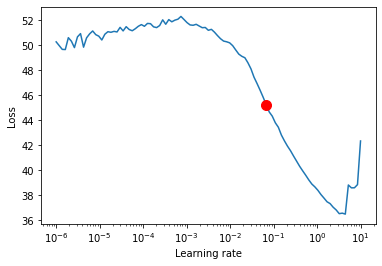

<ipython-input-100-a92b5627800b>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [100]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [101]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=res.suggestion(),
    hidden_size=16,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 21.9k


In [102]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.7 K 
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Global seed set to 22


Epoch 0:  38%|███▊      | 30/79 [00:23<00:37,  1.29it/s, loss=27.3, v_num=7, val_loss=70.90, train_loss_step=23.20]

Finding best initial lr: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Epoch 0:  39%|███▉      | 31/79 [00:23<00:36,  1.31it/s, loss=27.3, v_num=7, val_loss=70.90, train_loss_step=23.20]
Validating: 0it [00:00, ?it/s]
Epoch 1:  39%|███▉      | 31/79 [00:22<00:34,  1.40it/s, loss=24.9, v_num=7, val_loss=26.90, train_loss_step=27.50, train_loss_epoch=31.10]
Validating: 0it [00:00, ?it/s]
Epoch 2:  39%|███▉      | 31/79 [00:22<00:35,  1.36it/s, loss=23.1, v_num=7, val_loss=26.50, train_loss_step=20.40, train_loss_epoch=24.80]
Validating: 0it [00:00, ?it/s]
Epoch 3:  39%|███▉      | 31/79 [00:22<00:35,  1.37it/s, loss=24.8, v_num=7, val_loss=26.60, train_loss_step=22.90, train_loss_epoch=23.60]
Validating: 0it [00:00, ?it/s]
Epoch 4:  39%|███▉      | 31/79 [00:31<00:48,  1.02s/it, loss=23.1, v_num=7, val_loss=26.40, train_loss_step=26.50, train_loss_epoch=24.80]


Validating: 0it [00:00, ?it/s]
Epoch 5:  39%|███▉      | 31/79 [00:29<00:45,  1.06it/s, loss=23.8, v_num=7, val_loss=26.30, train_loss_step=25.40, train_loss_epoch=23.10]
Validating: 0it [00:00, ?it/s]
Epoch 6:  39%|███▉      | 31/79 [00:31<00:49,  1.02s/it, loss=22.6, v_num=7, val_loss=26.20, train_loss_step=20.70, train_loss_epoch=23.80]
Validating: 0it [00:00, ?it/s]
Epoch 7:  39%|███▉      | 31/79 [00:24<00:37,  1.27it/s, loss=23.8, v_num=7, val_loss=26.60, train_loss_step=20.90, train_loss_epoch=23.10]
Validating: 0it [00:00, ?it/s]
Epoch 8:  39%|███▉      | 31/79 [00:32<00:49,  1.03s/it, loss=22.8, v_num=7, val_loss=26.20, train_loss_step=21.70, train_loss_epoch=23.60]
Validating: 0it [00:00, ?it/s]
Epoch 8:  58%|█████▊    | 46/79 [00:51<00:36,  1.11s/it, loss=22.8, v_num=7, val_loss=26.20, train_loss_step=21.70, train_loss_epoch=23.60]


Epoch 9:  39%|███▉      | 31/79 [00:30<00:46,  1.03it/s, loss=23.2, v_num=7, val_loss=27.30, train_loss_step=27.60, train_loss_epoch=22.70]
Validating: 0it [00:00, ?it/s]
Epoch 10:  39%|███▉      | 31/79 [00:27<00:42,  1.12it/s, loss=23.4, v_num=7, val_loss=28.10, train_loss_step=20.40, train_loss_epoch=23.10]
Validating: 0it [00:00, ?it/s]
Epoch 11:  39%|███▉      | 31/79 [00:26<00:41,  1.16it/s, loss=21.5, v_num=7, val_loss=29.10, train_loss_step=22.60, train_loss_epoch=23.40]
Validating: 0it [00:00, ?it/s]
Epoch 12:  39%|███▉      | 31/79 [00:22<00:34,  1.40it/s, loss=20.1, v_num=7, val_loss=26.80, train_loss_step=23.30, train_loss_epoch=21.80]
Validating: 0it [00:00, ?it/s]
Epoch 12:  84%|████████▎ | 66/79 [00:41<00:08,  1.58it/s, loss=20.1, v_num=7, val_loss=26.80, train_loss_step=23.30, train_loss_epoch=21.80]


Epoch 13:  39%|███▉      | 31/79 [00:21<00:33,  1.44it/s, loss=19.5, v_num=7, val_loss=27.10, train_loss_step=21.60, train_loss_epoch=20.30]
Validating: 0it [00:00, ?it/s]
Epoch 14:  39%|███▉      | 31/79 [00:22<00:34,  1.38it/s, loss=19, v_num=7, val_loss=25.90, train_loss_step=20.30, train_loss_epoch=19.50]  
Validating: 0it [00:00, ?it/s]
Epoch 15:  39%|███▉      | 31/79 [00:25<00:38,  1.24it/s, loss=18.8, v_num=7, val_loss=24.90, train_loss_step=17.20, train_loss_epoch=19.50]
Validating: 0it [00:00, ?it/s]
Epoch 16:  39%|███▉      | 31/79 [00:30<00:46,  1.03it/s, loss=18.2, v_num=7, val_loss=23.70, train_loss_step=17.80, train_loss_epoch=18.80]
Validating: 0it [00:00, ?it/s]
Epoch 17:  39%|███▉      | 31/79 [00:25<00:39,  1.21it/s, loss=17.8, v_num=7, val_loss=24.10, train_loss_step=18.40, train_loss_epoch=18.30]
Validating: 0it [00:00, ?it/s]
Epoch 17:  43%|████▎     | 34/79 [00:44<00:58,  1.29s/it, loss=17.8, v_num=7, val_loss=24.10, train_loss_step=18.40, train_loss_epoch=18.30]

Epoch 18:  39%|███▉      | 31/79 [00:23<00:36,  1.32it/s, loss=17.6, v_num=7, val_loss=23.20, train_loss_step=16.10, train_loss_epoch=17.90]
Validating: 0it [00:00, ?it/s]
Epoch 19:  39%|███▉      | 31/79 [00:24<00:37,  1.27it/s, loss=17.1, v_num=7, val_loss=23.40, train_loss_step=17.60, train_loss_epoch=17.60]
Validating: 0it [00:00, ?it/s]
Epoch 20:  39%|███▉      | 31/79 [00:29<00:45,  1.07it/s, loss=17, v_num=7, val_loss=23.10, train_loss_step=20.70, train_loss_epoch=17.20]  
Validating: 0it [00:00, ?it/s]
Epoch 21:  39%|███▉      | 31/79 [00:27<00:41,  1.15it/s, loss=16.8, v_num=7, val_loss=23.80, train_loss_step=17.40, train_loss_epoch=17.10]
Validating: 0it [00:00, ?it/s]
Epoch 21:  65%|██████▍   | 51/79 [00:47<00:25,  1.08it/s, loss=16.8, v_num=7, val_loss=23.80, train_loss_step=17.40, train_loss_epoch=17.10]


Epoch 22:  39%|███▉      | 31/79 [00:32<00:50,  1.06s/it, loss=17.4, v_num=7, val_loss=24.10, train_loss_step=15.00, train_loss_epoch=17.10]
Validating: 0it [00:00, ?it/s]
Epoch 23:  39%|███▉      | 31/79 [00:30<00:47,  1.01it/s, loss=19.3, v_num=7, val_loss=23.90, train_loss_step=20.80, train_loss_epoch=17.40]
Validating: 0it [00:00, ?it/s]
Epoch 24:  39%|███▉      | 31/79 [00:27<00:42,  1.13it/s, loss=19.3, v_num=7, val_loss=28.40, train_loss_step=16.70, train_loss_epoch=18.70]
Validating: 0it [00:00, ?it/s]
Epoch 25:  39%|███▉      | 31/79 [00:27<00:41,  1.15it/s, loss=17.7, v_num=7, val_loss=25.10, train_loss_step=18.50, train_loss_epoch=20.00]
Validating: 0it [00:00, ?it/s]
Epoch 25:  67%|██████▋   | 53/79 [00:48<00:23,  1.09it/s, loss=17.7, v_num=7, val_loss=25.10, train_loss_step=18.50, train_loss_epoch=20.00]


Epoch 26:  39%|███▉      | 31/79 [00:26<00:41,  1.15it/s, loss=17.2, v_num=7, val_loss=25.40, train_loss_step=16.00, train_loss_epoch=17.70]
Validating: 0it [00:00, ?it/s]
Epoch 27:  39%|███▉      | 31/79 [00:27<00:42,  1.12it/s, loss=18.3, v_num=7, val_loss=25.80, train_loss_step=22.70, train_loss_epoch=17.00]
Validating: 0it [00:00, ?it/s]
Epoch 28:  39%|███▉      | 31/79 [00:26<00:40,  1.19it/s, loss=18.1, v_num=7, val_loss=26.50, train_loss_step=19.60, train_loss_epoch=17.90]
Validating: 0it [00:00, ?it/s]
Epoch 29:  39%|███▉      | 31/79 [00:25<00:39,  1.21it/s, loss=18.1, v_num=7, val_loss=27.30, train_loss_step=18.60, train_loss_epoch=18.20]
Validating: 0it [00:00, ?it/s]
Epoch 29:  82%|████████▏ | 65/79 [00:46<00:10,  1.39it/s, loss=18.1, v_num=7, val_loss=27.30, train_loss_step=18.60, train_loss_epoch=18.20]


Epoch 30:  39%|███▉      | 31/79 [00:24<00:37,  1.29it/s, loss=18.4, v_num=7, val_loss=26.80, train_loss_step=20.80, train_loss_epoch=18.10]
Validating: 0it [00:00, ?it/s]
Epoch 31:  39%|███▉      | 31/79 [00:26<00:41,  1.16it/s, loss=18.9, v_num=7, val_loss=26.90, train_loss_step=23.00, train_loss_epoch=18.40]
Validating: 0it [00:00, ?it/s]
Epoch 32:  39%|███▉      | 31/79 [00:25<00:40,  1.19it/s, loss=19.5, v_num=7, val_loss=27.10, train_loss_step=18.60, train_loss_epoch=19.00]
Validating: 0it [00:00, ?it/s]
Epoch 33:  39%|███▉      | 31/79 [00:25<00:40,  1.20it/s, loss=20.1, v_num=7, val_loss=28.00, train_loss_step=19.40, train_loss_epoch=19.60]
Validating: 0it [00:00, ?it/s]
Epoch 33:  92%|█████████▏| 73/79 [00:47<00:03,  1.53it/s, loss=20.1, v_num=7, val_loss=28.00, train_loss_step=19.40, train_loss_epoch=19.60]


Epoch 34:  39%|███▉      | 31/79 [00:25<00:38,  1.23it/s, loss=18.9, v_num=7, val_loss=27.70, train_loss_step=17.80, train_loss_epoch=20.10]
Validating: 0it [00:00, ?it/s]
Epoch 35:  39%|███▉      | 31/79 [00:24<00:38,  1.25it/s, loss=19.2, v_num=7, val_loss=27.60, train_loss_step=17.60, train_loss_epoch=18.80]
Validating: 0it [00:00, ?it/s]
Epoch 36:  39%|███▉      | 31/79 [00:26<00:40,  1.18it/s, loss=19, v_num=7, val_loss=27.50, train_loss_step=19.70, train_loss_epoch=19.20]  
Validating: 0it [00:00, ?it/s]
Epoch 37:  39%|███▉      | 31/79 [17:18<26:48, 33.51s/it, loss=19.5, v_num=7, val_loss=27.50, train_loss_step=19.90, train_loss_epoch=19.30]    
Validating: 0it [00:00, ?it/s]
Epoch 38:  39%|███▉      | 31/79 [12:56<20:02, 25.04s/it, loss=19.2, v_num=7, val_loss=27.50, train_loss_step=19.80, train_loss_epoch=19.00]   
Validating: 0it [00:00, ?it/s]
Epoch 38:  43%|████▎     | 34/79 [13:26<17:46, 23.71s/it, loss=19.2, v_num=7, val_loss=27.50, train_loss_step=19.80, train_loss_epoch

Epoch 39:  39%|███▉      | 31/79 [00:31<00:49,  1.03s/it, loss=19.1, v_num=7, val_loss=27.50, train_loss_step=20.80, train_loss_epoch=19.20]
Validating: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████| 79/79 [00:57<00:00,  1.37it/s, loss=19.1, v_num=7, val_loss=27.40, train_loss_step=18.00, train_loss_epoch=19.10]
